In [86]:
import numpy as np
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [87]:
raw_train_data = pd.read_csv("D:\\fliprobo\\Fake news project\\train_news.csv")

In [88]:
raw_train_data.head(5)

,Unnamed: 0,id,headline,written_by,news,label
0,0,9653,Ethics Questions Dogged Agriculture Nominee as...,Eric Lipton and Steve Eder,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0
1,1,10041,U.S. Must Dig Deep to Stop Argentina’s Lionel ...,David Waldstein,HOUSTON — Venezuela had a plan. It was a ta...,0
2,2,19113,Cotton to House: ’Do Not Walk the Plank and Vo...,Pam Key,"Sunday on ABC’s “This Week,” while discussing ...",0
3,3,6868,"Paul LePage, Besieged Maine Governor, Sends Co...",Jess Bidgood,"AUGUSTA, Me. — The beleaguered Republican g...",0
4,4,7596,A Digital 9/11 If Trump Wins,Finian Cunningham,Finian Cunningham has written extensively on...,1


In [89]:
raw_train_data.isnull().sum()

Unnamed: 0       0
id               0
headline       558
written_by    1957
news            39
label            0
dtype: int64

In [90]:
#We can see news column has 39 records where there is no data in column. We will have to work on this null data.

In [91]:
raw_train_data.columns

Index(['Unnamed: 0', 'id', 'headline', 'written_by', 'news', 'label'], dtype='object')

In [92]:
raw_train_data.drop('id',axis=1,inplace=True)
raw_train_data.drop('Unnamed: 0',axis=1,inplace=True)
raw_train_data.drop('headline',axis=1,inplace=True)
raw_train_data.drop('written_by',axis=1,inplace=True)

In [93]:
#since we are interested in news and label column whether is it fake news or not, we are deleting other columns from dataset.

In [94]:
raw_train_data.news.fillna("IGNORE TEXT", inplace = True)

#Here we are replacing NULL/ missing values with 'IGNORE TEXT' hard coded value.

In [95]:
raw_train_data.isnull().sum()

news     0
label    0
dtype: int64

<AxesSubplot:>

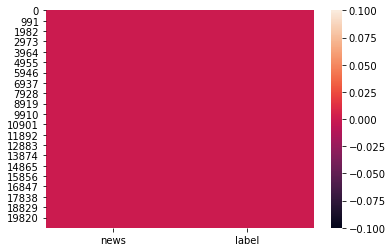

In [96]:
sns.heatmap(raw_train_data.isnull()) #Heatmap also indicates that now there are no more null vallues in our dataset.

In [97]:
#raw_train_data.describe()

In [98]:
from nltk.stem import WordNetLemmatizer
import nltk
from nltk.corpus import  stopwords
import string

In [99]:
raw_train_data['news_length'] = raw_train_data['news'].str.len() # Here we have added 'news_lenth' column at end of our dataset 

In [100]:
raw_train_data.head(5)

,news,label,news_length
0,"WASHINGTON — In Sonny Perdue’s telling, Geo...",0,7936
1,HOUSTON — Venezuela had a plan. It was a ta...,0,6112
2,"Sunday on ABC’s “This Week,” while discussing ...",0,425
3,"AUGUSTA, Me. — The beleaguered Republican g...",0,6516
4,Finian Cunningham has written extensively on...,1,9164


In [101]:
# Convert all messages to lower case
raw_train_data['news'] = raw_train_data['news'].str.lower()

# Replace email addresses with 'email'
raw_train_data['news'] = raw_train_data['news'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')

# Replace URLs with 'webaddress'
raw_train_data['news'] = raw_train_data['news'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$',
                                                                            'webaddress')

# Replace money symbols with 'moneysymb' (£ can by typed with ALT key + 156)
raw_train_data['news'] = raw_train_data['news'].str.replace(r'£|\$', 'dollers')
    
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
raw_train_data['news'] = raw_train_data['news'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$',
                                                                            'phonenumber')

    
# Replace numbers with 'numbr'
raw_train_data['news'] = raw_train_data['news'].str.replace(r'\d+(\.\d+)?', 'numbr')


raw_train_data['news'] = raw_train_data['news'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in string.punctuation))
#Here we are removing punctation characters from our dataset.

stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
raw_train_data['news'] = raw_train_data['news'].apply(lambda x: ' '.join(
    term for term in x.split() if term not in stop_words))
#Here we are removing stop words from our dataset to clean our data.

lem=WordNetLemmatizer()
raw_train_data['news'] = raw_train_data['news'].apply(lambda x: ' '.join(
    lem.lemmatize(t) for t in x.split()))

#here we are using WordNetLemmatizer to break entries in colum 'news' into seperate meaningful words

In [102]:
raw_train_data['news_clean_length'] = raw_train_data.news.str.len()
raw_train_data.head()

,news,label,news_length,news_clean_length
0,"washington — sonny perdue’s telling, georgian ...",0,7936,5846
1,"houston — venezuela plan. tactical approach, d...",0,6112,4463
2,"sunday abc’s “this week,” discussing republica...",0,425,301
3,"augusta, me. — beleaguered republican governor...",0,6516,4744
4,finian cunningham written extensively internat...,1,9164,6914


In [103]:
#Now we can see after cleaning and transforming news data, length of this column has reduce to good extent. 

In [104]:
# Total length removal
print ('Origian Length', raw_train_data.news_length.sum())
print ('Clean Length', raw_train_data.news_clean_length.sum())

Origian Length 94519353
Clean Length 69447513


In [105]:
# From above length removal count we can see around 26.5% of data is reduced which formed part of data noise/ non-required data
#like stop words, punctation, etc. This will be very helpful to optimize and increase the performance of our model.

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,f1_score,roc_curve,roc_auc_score,auc
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [107]:
#  Convert text into vectors using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
tf_vec = TfidfVectorizer(max_features = 10000, stop_words='english')
features = tf_vec.fit_transform(raw_train_data['news'])
x = features

In [108]:
raw_train_data.shape

(20800, 4)

In [109]:
raw_train_data.head(4)

,news,label,news_length,news_clean_length
0,"washington — sonny perdue’s telling, georgian ...",0,7936,5846
1,"houston — venezuela plan. tactical approach, d...",0,6112,4463
2,"sunday abc’s “this week,” discussing republica...",0,425,301
3,"augusta, me. — beleaguered republican governor...",0,6516,4744


In [110]:
y = raw_train_data['label']

In [111]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=56,test_size=.30)

In [112]:
y_train.shape, x_train.shape

((14560,), (14560, 10000))

In [113]:
y_test.shape, x_test.shape

((6240,), (6240, 10000))

In [114]:
models = [LogisticRegression(),DecisionTreeClassifier(),KNeighborsClassifier(),RandomForestClassifier()]

for i in models:
    print(i)
    #i.fit(x_train, y_train)
    i.fit(x_train, y_train)
    y_pred_test = i.predict(x_test)
    print('Test accuracy of:',i,'is {}'.format(accuracy_score(y_test,y_pred_test)))

LogisticRegression()
Test accuracy of: LogisticRegression() is 0.9479166666666666
DecisionTreeClassifier()
Test accuracy of: DecisionTreeClassifier() is 0.8878205128205128
KNeighborsClassifier()
Test accuracy of: KNeighborsClassifier() is 0.6065705128205128
RandomForestClassifier()
Test accuracy of: RandomForestClassifier() is 0.9439102564102564


In [115]:
# From above model accuracy scores, we can see Logistic Regression and Random ForrestClassifier algorithmns have almost similar
# score and it is also quite good to be considered in terms of model performance.

In [116]:
#Here we use cross validation technique wuth Logistic regression to rotate entire dataset in train and test mode with 5 rounds 
cross_score=cross_val_score(RandomForestClassifier(),x,y,cv=5)
print("Cross validation score=", cross_score)
print("Cross validation mean score=", cross_score.mean())
print("Cross validation standard deviation score=", cross_score.std())

Cross validation score= [0.94423077 0.93413462 0.94254808 0.946875   0.94399038]
Cross validation mean score= 0.9423557692307692
Cross validation standard deviation score= 0.0043413221951805045


In [117]:
#Here we can see cross validation mean score is also 94.04% which indicated that our model performance is also good.

In [118]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [119]:
abc = AdaBoostClassifier(n_estimators=50,base_estimator=RandomForestClassifier(),learning_rate=1,algorithm='SAMME')
lr=RandomForestClassifier()
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.20,random_state=56)
abc.fit(x_train,y_train)
predlr = abc.predict(x_test)
print("Accuracy score:",accuracy_score(predlr,y_test))
print("Predicted values using AdaBoostClassifier model:\n",predlr)

Accuracy score: 0.9432692307692307
Predicted values using AdaBoostClassifier model:
 [0 0 1 ... 1 1 0]


In [120]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]
temp_score = 0
temp_rate = 0
for i in lr_list:
    gb_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=i, max_features=2, max_depth=2, random_state=56)
    gb_clf.fit(x_train,y_train)   
    score = gb_clf.score(x_test, y_test)
    if score > temp_score:
        temp_score = score
        temp_rate = i
print("Best learnin rate is:",temp_rate)
print("Best learning score is:",temp_score)

Best learnin rate is: 1
Best learning score is: 0.6658653846153846


In [121]:
#gb_clf = GradientBoostingClassifier(n_estimators=50, learning_rate=temp_rate, max_features=2, max_depth=2, random_state=56)
#gb_clf.fit(x_train,y_train)
#predgb = gb_clf.predict(x_test)
#score = gb_clf.score(x_test, y_test)
#print("Accuracy score of GradientBoostingClassifier is:",accuracy_score(predgb,y_test))

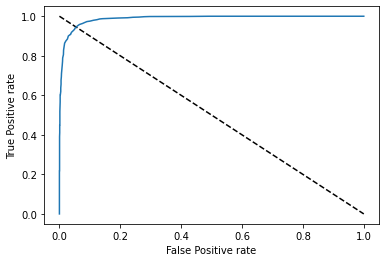

In [122]:
rfc = RandomForestClassifier().fit(x_train, y_train)
probability = rfc.predict_proba(x_test)[:,1]
probability
fpr,tpr,threshold = roc_curve(y_test,probability,pos_label=True)
#print(fpr)
#print(tpr)
#print(threshold)
plt.plot([0,1],[1,0],'k--')
plt.plot(fpr,tpr,label = "RandomForestClassifier")
plt.xlabel("False Positive rate")
plt.ylabel("True Positive rate")
plt.show()

In [123]:
#By looking at accuracy score, cross validation mean score and AUC_ROC curve of RandomForestClassifier algorithm, we can infer
#that this model gives a good performance and hence we will use RandomForestClassifier in our final model. 

In [124]:
rfc_final = RandomForestClassifier()
rfc_final.fit(x_train, y_train)
rfc_pred_test = rfc_final.predict(x_test)
print("Predicted values using RandomForestClassifier model:\n",rfc_pred_test)

Predicted values using RandomForestClassifier model:
 [0 0 1 ... 1 1 0]


In [125]:
fake_news_prediction_file = pd.DataFrame(rfc_pred_test)

In [126]:
fake_news_prediction_file.to_csv("D:\\fliprobo\\Fake news project\\fake_news_prediction.csv",header=0)

In [127]:
import pickle
filename = 'D:\\fliprobo\\Fake news project\\fake_news_prediction.pkl'
pickle.dump(rfc,open(filename,'wb'))